# Countries Explorative Data Analysis (EDA)

In [31]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import time

## Overview
The data contains information about 186 countries.
The data can help analyze the population, area, and different details about the countries

## Questions for Analysis
1. What is the population distribution?
2. What is the most and least populated country?
3. What is the most and least populated continent?
4. What is the country with the largest and smallest average area?
5. What is the continent with the largest and smallest average area?
6. What is the country with the most inequality of wealth?
7. What is the continent with the most/least equality of wealth?
8. What is the most spoken language in the world?
9. How many countries drive on the left side?
10. How many countries are still not independant?
11. What is the continent with the most countries?
12. What country got his independence last?

## About Dataset

The dataset contains information about all the 250 delegations in the world. The datasetcomes from two different APIs and websites
- [REST Countries API](https://restcountries.com/)
- [Restful Countries API](https://restfulcountries.com/)
- [World Bank Group](https://datacatalog.worldbank.org/search/dataset/0038130)

### Columns description
- ```gini``` GINI Coefficient or GINI Index. It measures inequality on a scale from 0 to 1, 0 being perfect equality and 1 (100%) perfect inequality. 
- ```gdp``` Gross Domestic Product (GDP), in millions of US Dollars
- c
- d
- e

## Data Collection

### Create CSV file from first API

In [37]:
# Handle ChunkedEncodingError by adding 'try except' and adding 1 second pause between each attempt
for attempt in range(5):
    country_list = []
    
    try:
        response = requests.get('https://restcountries.com/v3.1/all')
        
        if response.status_code != 200:
            print('Failed to find data')

        countriesJson = json.loads(response.content)

        # Collect relevant columns
        for item in countriesJson:
            keys = item.keys()
            country = {
                'name': item['name']['common'],
                'cca3': item['cca3'],
                'continent' : item['continents'][0],
                'area': item['area'],
                'car_side': item['car']['side'],
                'population': item['population'],
                'gini': list(item['gini'].values())[0] if 'gini' in keys else None,
                'languages': ', '.join(list(item['languages'].values())) if 'languages' in keys else None
            }
            country_list.append(country)

        header = country_list[0].keys()

        # Create/replace CSV file
        with open('Data/countries1.csv', 'w', newline='') as output_file:
            dict_writer = csv.DictWriter(output_file, header)
            dict_writer.writeheader()
            dict_writer.writerows(country_list)
            output_file.close()
            print('CSV file', output_file.name, 'created')
    
        break
    except requests.exceptions.ChunkedEncodingError:
        time.sleep(1)
else:
    print('Failed to fetch data from REST countries API')

CSV file Data/countries1.csv created


### Create CSV file from second API

In [39]:
# Request data
api_key = '1787|qM666AtNiFBX3PjiuCjngNuBXh9VyRdggx94r1Hr'
url = 'https://restfulcountries.com/api/v1/countries'
headers = {'Accept': 'application/json', 'Authorization': 'Bearer' + ' ' + api_key}
                                
try:
    country_list2 = []
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print('Failed to find data')
    
    countries2Json = json.loads(response.content)['data']
    
    # Collect relevant columns
    for item in countries2Json:
        country = {
            'name': item['name'],
            'iso3': item['iso3'],
            'capital': item['capital'],
            'currency': item['currency'],
        }
        country_list2.append(country)
    
    header = country_list2[0].keys()
    
    # Create/replace CSV file
    with open('Data/countries2.csv', 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, header)
        dict_writer.writeheader()
        dict_writer.writerows(country_list2)
        output_file.close()
        print('CSV file', output_file.name, 'created')
        
except:
    print('Failed to fetch data from Restful Countries API')

CSV file Data/countries2.csv created


### Create dataframe from the 3 CSV files

In [276]:
# Get number of rows/columns of each dataframe
countries1 = pd.read_csv('Data/countries1.csv')
print('Countries 1 shape:', countries1.shape)

countries2 = pd.read_csv('Data/countries2.csv')
print('Countries 2 shape:', countries2.shape)

gdp = pd.read_csv('Data/GDP.csv', on_bad_lines='error')
print('GDP shape:', gdp.shape)

Countries 1 shape: (250, 8)
Countries 2 shape: (186, 4)
GDP shape: (217, 4)


In [278]:
# Merge dataframes
countries = countries1 \
    .merge(right=countries2, how='inner', left_on='cca3', right_on='iso3') \
    .merge(right=gdp, how='inner', left_on='cca3', right_on='code')
print('Merged dataframe shape:', countries.shape)

Merged dataframe shape: (185, 16)


## Data Exploration

In [256]:
countries.head()

,name_x,cca3,continent,area,car_side,population,gini,languages,name_y,iso3,capital,currency,code,rank,country,gdp
0,Grenada,GRD,North America,344,left,112519,NaN,English,Grenada,GRD,St. George's,XCD,GRD,193,Grenada,"1,320"
1,Switzerland,CHE,Europe,41284,right,8654622,33,"French, Swiss German, Italian, Romansh",Switzerland,CHE,Berne,CHF,CHE,20,Switzerland,"884,940"
2,Sierra Leone,SLE,Africa,71740,right,7976985,36,English,Sierra Leone,SLE,Freetown,SLL,SLE,169,Sierra Leone,"3,810"
3,Hungary,HUN,Europe,93028,right,9749763,30,Hungarian,Hungary,HUN,Budapest,HUF,HUN,56,Hungary,"212,389"
4,Barbados,BRB,North America,430,left,287371,NaN,English,Barbados,BRB,Bridgetown,BBD,BRB,162,Barbados,"6,394"


In [258]:
countries.tail()

,name_x,cca3,continent,area,car_side,population,gini,languages,name_y,iso3,capital,currency,code,rank,country,gdp
180,Republic of the Congo,COG,Africa,342000,right,5657000,49,"French, Kikongo, Lingala",Congo,COG,Brazzaville,XAF,COG,134,"Congo, Rep.","15,321"
181,Belgium,BEL,Europe,30528,right,11555997,27,"German, French, Dutch",Belgium,BEL,Brussels,EUR,BEL,23,Belgium,"632,217"
182,Israel,ISR,Asia,20770,right,9216900,39,"Arabic, Hebrew",Israel,ISR,Jerusalem,ILS,ISR,28,Israel,"509,901"
183,New Zealand,NZL,Oceania,270467,left,5084300,NaN,"English, Māori, New Zealand Sign Language",New Zealand,NZL,Wellington,NZD,NZL,51,New Zealand,"253,466"
184,Nicaragua,NIC,North America,130373,right,6624554,46,Spanish,Nicaragua,NIC,Managua,NIO,NIC,127,Nicaragua,"17,829"


In [263]:
countries.sample(5)

,name_x,cca3,continent,area,car_side,population,gini,languages,name_y,iso3,capital,currency,code,rank,country,gdp
170,Poland,POL,Europe,312679,right,37950802,30,Polish,Poland,POL,Warsaw,PLN,POL,21,Poland,"811,229"
124,Turkmenistan,TKM,Asia,488100,right,6031187,41,"Russian, Turkmen",Turkmenistan,TKM,Ashgabat,TMT,TKM,88,Turkmenistan,"59,887"
129,Norway,NOR,Europe,323802,right,5379475,28,"Norwegian Nynorsk, Norwegian Bokmål, Sami",Norway,NOR,Oslo,NOK,NOR,31,Norway,"485,513"
132,Eritrea,ERI,Africa,117600,right,5352000,NaN,"Arabic, English, Tigrinya",Eritrea,ERI,Asmara,ERN,ERI,NaN,Eritrea,
133,Tanzania,TZA,Africa,945087,left,59734213,40,"English, Swahili",Tanzania,TZA,Dodoma,TZS,TZA,77,Tanzania,"79,158"


In [266]:
countries.dtypes

name_x         object
cca3           object
continent      object
area          float64
car_side       object
population      int64
gini          float64
languages      object
name_y         object
iso3           object
capital        object
currency       object
code           object
rank          float64
country        object
gdp            object
dtype: object

In [268]:
countries.describe()

,area,population,gini,rank
count,185,185,159,180
mean,706980,40675690,38,98
std,1949915,149390939,8,59
min,2,10834,25,1
25%,27750,2142252,33,49
50%,143100,8947027,37,96
75%,551695,29136808,43,143
max,17098242,1402112000,63,208


In [270]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name_x      185 non-null    object 
 1   cca3        185 non-null    object 
 2   continent   185 non-null    object 
 3   area        185 non-null    float64
 4   car_side    185 non-null    object 
 5   population  185 non-null    int64  
 6   gini        159 non-null    float64
 7   languages   185 non-null    object 
 8   name_y      185 non-null    object 
 9   iso3        185 non-null    object 
 10  capital     185 non-null    object 
 11  currency    185 non-null    object 
 12  code        185 non-null    object 
 13  rank        180 non-null    float64
 14  country     185 non-null    object 
 15  gdp         185 non-null    object 
dtypes: float64(3), int64(1), object(12)
memory usage: 23.3+ KB


There are only missing values in the ```gini``` column. We will not remove the rows.

## Data Preparation

In [280]:
# Drop the name column of the second and third dataframe
countries = countries.drop(['name_y', 'country'], axis=1).rename(columns={'name_x': 'name'})
countries.head()

,name,cca3,continent,area,car_side,population,gini,languages,iso3,capital,currency,code,rank,gdp
0,Grenada,GRD,North America,344,left,112519,NaN,English,GRD,St. George's,XCD,GRD,193,"1,320"
1,Switzerland,CHE,Europe,41284,right,8654622,33,"French, Swiss German, Italian, Romansh",CHE,Berne,CHF,CHE,20,"884,940"
2,Sierra Leone,SLE,Africa,71740,right,7976985,36,English,SLE,Freetown,SLL,SLE,169,"3,810"
3,Hungary,HUN,Europe,93028,right,9749763,30,Hungarian,HUN,Budapest,HUF,HUN,56,"212,389"
4,Barbados,BRB,North America,430,left,287371,NaN,English,BRB,Bridgetown,BBD,BRB,162,"6,394"


In [282]:
# Drop the code column of the second dataframe
countries = countries.drop(['iso3', 'code'], axis=1).rename(columns={'cca3': 'code'})
countries.head()

,name,code,continent,area,car_side,population,gini,languages,capital,currency,rank,gdp
0,Grenada,GRD,North America,344,left,112519,NaN,English,St. George's,XCD,193,"1,320"
1,Switzerland,CHE,Europe,41284,right,8654622,33,"French, Swiss German, Italian, Romansh",Berne,CHF,20,"884,940"
2,Sierra Leone,SLE,Africa,71740,right,7976985,36,English,Freetown,SLL,169,"3,810"
3,Hungary,HUN,Europe,93028,right,9749763,30,Hungarian,Budapest,HUF,56,"212,389"
4,Barbados,BRB,North America,430,left,287371,NaN,English,Bridgetown,BBD,162,"6,394"


In [284]:
# Remove whitespaces from string columns
countries['name'] = countries['name'].str.strip()
countries['code'] = countries['code'].str.strip()
countries['continent'] = countries['continent'].str.strip()
countries['car_side'] = countries['car_side'].str.strip()
countries['capital'] = countries['capital'].str.strip()
countries['currency'] = countries['currency'].str.strip()
countries.head()

,name,code,continent,area,car_side,population,gini,languages,capital,currency,rank,gdp
0,Grenada,GRD,North America,344,left,112519,NaN,English,St. George's,XCD,193,"1,320"
1,Switzerland,CHE,Europe,41284,right,8654622,33,"French, Swiss German, Italian, Romansh",Berne,CHF,20,"884,940"
2,Sierra Leone,SLE,Africa,71740,right,7976985,36,English,Freetown,SLL,169,"3,810"
3,Hungary,HUN,Europe,93028,right,9749763,30,Hungarian,Budapest,HUF,56,"212,389"
4,Barbados,BRB,North America,430,left,287371,NaN,English,Bridgetown,BBD,162,"6,394"


In [300]:
# Drop capital, currency and rank from dataframe
countries = countries.drop(['capital', 'currency', 'rank'], axis=1)
countries.sample()

KeyError: "['capital', 'currency', 'rank'] not found in axis"

In [294]:
# Convert gdp column to float, NaN if empty
countries['gdp'] = countries['gdp'] \
    .str.replace(',', '') \
    .replace(r'^\s*$', np.nan, regex=True) \
    .astype('float')
countries.dtypes

name           object
code           object
continent      object
area          float64
car_side       object
population      int64
gini          float64
languages      object
capital        object
currency       object
rank          float64
gdp           float64
dtype: object

In [302]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        185 non-null    object 
 1   code        185 non-null    object 
 2   continent   185 non-null    object 
 3   area        185 non-null    float64
 4   car_side    185 non-null    object 
 5   population  185 non-null    int64  
 6   gini        159 non-null    float64
 7   languages   185 non-null    object 
 8   gdp         180 non-null    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 13.1+ KB


In [55]:
# Sort countries in alphabetical order and reset index
countries = countries.sort_values(by='name').reset_index(drop=True)
countries.head(5)

,name,code,continent,area,car_side,population,gini,languages,capital,currency
0,Afghanistan,AFG,Asia,652230.0,right,40218234,NaN,"Dari, Pashto, Turkmen",Kabul,AFN
1,Albania,ALB,Europe,28748.0,right,2837743,33.2,Albanian,Tirana,lek
2,Algeria,DZA,Africa,2381741.0,right,44700000,27.6,Arabic,Algiers,DZD
3,Andorra,AND,Europe,468.0,right,77265,NaN,Catalan,Andorra la Vella,EUR
4,Angola,AGO,Africa,1246700.0,right,32866268,51.3,Portuguese,Luanda,AOA


In [56]:
countries.tail()

,name,code,continent,area,car_side,population,gini,languages,capital,currency
181,Venezuela,VEN,South America,916445.0,right,28435943,44.8,Spanish,Caracas,VEF
182,Vietnam,VNM,Asia,331212.0,right,97338583,35.7,Vietnamese,Hanoi,VND
183,Yemen,YEM,Asia,527968.0,right,29825968,36.7,Arabic,Sanaa,YER
184,Zambia,ZMB,Africa,752612.0,left,18383956,57.1,English,Lusaka,ZMK
185,Zimbabwe,ZWE,Africa,390757.0,left,14862927,50.3,"Chibarwe, English, Kalanga, Khoisan, Ndau, Nor...",Harare,ZWL


## Data Analysis

### Population

#### 1. What are the 10 most populated countries?

In [60]:
# Data

#remove scientific notation
pd.options.display.float_format = '{:.0f}'.format 

top_10_pop_countries = countries \
    .nlargest(n=10, columns='population')[['name', 'population']] \
    .set_index('name')

top_10_pop_countries

,population
name,
China,1402112000
India,1380004385
United States,329484123
Indonesia,273523621
Pakistan,220892331
Brazil,212559409
Nigeria,206139587
Bangladesh,164689383
Russia,144104080


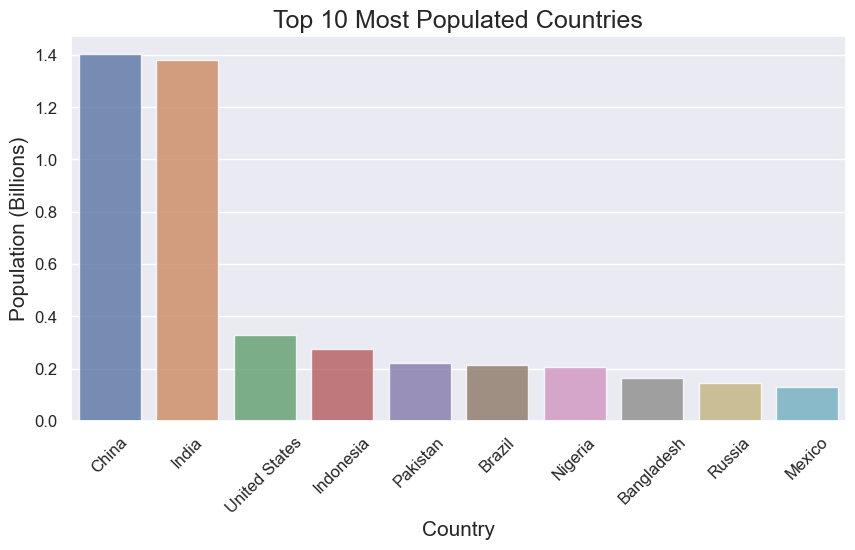

In [61]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_10_pop_countries,
                 x=top_10_pop_countries.index,
                 y=top_10_pop_countries['population'],
                 hue=top_10_pop_countries.index,
                 alpha=0.8)

# labels
ax.set_title('Top 10 Most Populated Countries', fontsize=18)
ax.set_xlabel('Country')
ax.set_ylabel('Population (Billions)')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', rotation=45)

# remove scientific notation showing at the top of the y axis
ax.yaxis.offsetText.set_visible(False)

plt.show()

India has surpassed China in population in April 2023 but the data is not the most recent. That's why it show China as the first.

#### 2. What are the top 2 most populated countries by continent?

In [64]:
# Data

countries \
    .sort_values(by=['continent', 'population'], ascending=[True, False]) \
    .groupby('continent') \
    .head(2)[['continent', 'name', 'population']] \
    .reset_index(drop=True)

,continent,name,population
0,Africa,Nigeria,206139587
1,Africa,Ethiopia,114963583
2,Asia,China,1402112000
3,Asia,India,1380004385
4,Europe,Russia,144104080
5,Europe,Turkey,84339067
6,North America,United States,329484123
7,North America,Mexico,128932753
8,Oceania,Australia,25687041
9,Oceania,Papua New Guinea,8947027


#### 3. What is the most populated continent?

In [66]:
# Data

total_pop_by_continent = countries \
    .groupby('continent')[['population']] \
    .sum() \
    .sort_values(by='population', ascending=False)

total_pop_by_continent

,population
continent,
Asia,4418314644
Africa,1251496732
Europe,820511088
North America,585297651
South America,430638593
Oceania,42247326


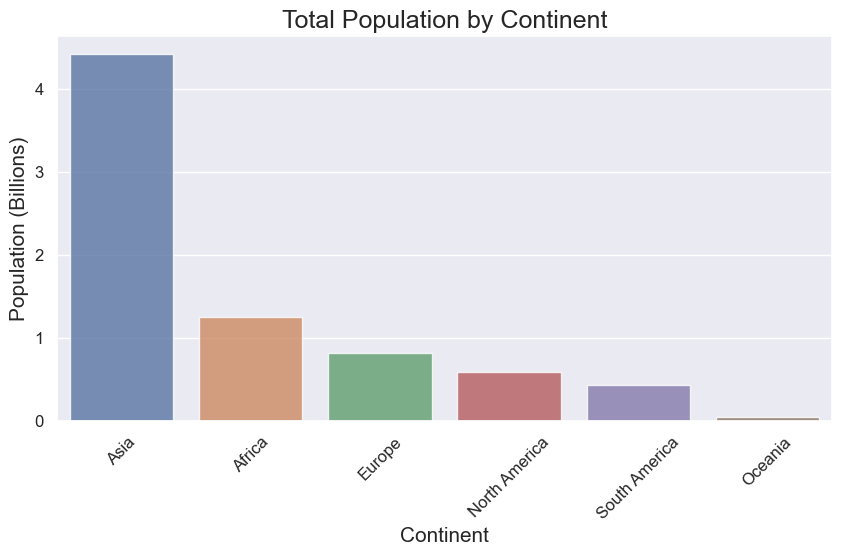

In [67]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=total_pop_by_continent,
                 x=total_pop_by_continent.index,
                 y=total_pop_by_continent['population'],
                 hue=total_pop_by_continent.index,
                 alpha=0.8)

# labels
ax.set_title('Total Population by Continent', fontsize=18)
ax.set_xlabel('Continent')
ax.set_ylabel('Population (Billions)')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', rotation=45)

# remove scientific notation showing at the top of the y axis
ax.yaxis.offsetText.set_visible(False)

plt.show()

The most populated continent is Asia.

### Area

#### 4. What are the top 20 largest countries?

In [161]:
# Data

top_20_largest_countries = countries \
    .nlargest(n=20, columns='area')[['name', 'area']] \
    .set_index('name')

top_20_largest_countries

,area
name,
Russia,17098242
Canada,9984670
China,9706961
United States,9372610
Brazil,8515767
Australia,7692024
India,3287590
Argentina,2780400
Kazakhstan,2724900


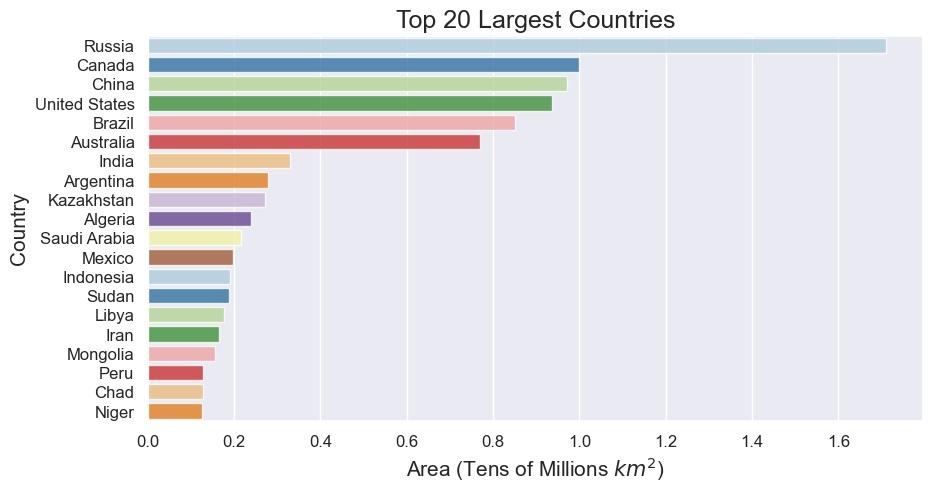

In [167]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_20_largest_countries,
                 x=top_20_largest_countries['area'],
                 y=top_20_largest_countries.index,
                 hue=top_20_largest_countries.index,
                 alpha=0.8,
                 palette='Paired',
                 orient='h')

# labels
ax.set_title('Top 20 Largest Countries', fontsize=18)
ax.set_xlabel('Area (Tens of Millions $km^2$)')
ax.set_ylabel('Country')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)

# remove scientific notation showing at the end of the x axis
ax.xaxis.offsetText.set_visible(False)

plt.show()

#### 5. What are the top 2 largest countries by continent?

In [74]:
# Data

countries \
    .sort_values(by=['continent', 'area'], ascending=[True, False]) \
    .groupby('continent') \
    .head(2)[['continent', 'name', 'area']] \
    .reset_index(drop=True)

,continent,name,area
0,Africa,Algeria,2381741
1,Africa,Sudan,1886068
2,Asia,China,9706961
3,Asia,India,3287590
4,Europe,Russia,17098242
5,Europe,Turkey,783562
6,North America,Canada,9984670
7,North America,United States,9372610
8,Oceania,Australia,7692024
9,Oceania,Papua New Guinea,462840


#### 6. What is the largest continent?

In [76]:
# Data

total_area_by_continent = countries \
    .groupby('continent')[['area']] \
    .sum() \
    .sort_values(by='area', ascending=False)

total_area_by_continent

,area
continent,
Asia,31025003
Africa,27700187
Europe,23810844
North America,22063274
South America,17737675
Oceania,8490477


The largest continent is Asia.

### Driving Side

#### 7. What is the proportion of countries driving on the left vs. right side?

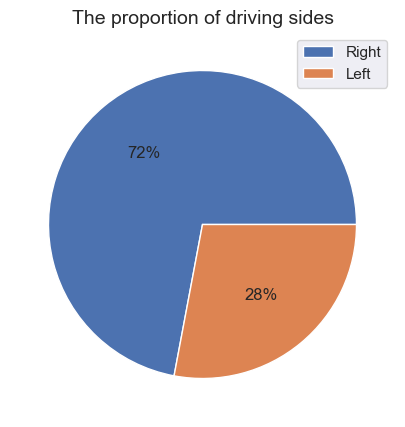

In [80]:
# Visualization
driving_sides = countries['car_side'].value_counts()
plt.pie(driving_sides, autopct='%.0f%%')
plt.title('The proportion of driving sides', fontsize=14)
plt.legend(labels=driving_sides.index.str.title())
plt.show()

#### 8. What are the countries driving on the left side?

In [169]:
left_car_side = countries[countries['car_side'] == 'left']
left_car_side.sample(5)

,name,code,continent,area,car_side,population,gini,languages,capital,currency
185,Zimbabwe,ZWE,Africa,390757,left,14862927,50,"Chibarwe, English, Kalanga, Khoisan, Ndau, Nor...",Harare,ZWL
115,Namibia,NAM,Africa,825615,left,2540916,59,"Afrikaans, German, English, Herero, Khoekhoe, ...",Windhoek,NAD
168,Trinidad and Tobago,TTO,North America,5130,left,1399491,40,English,Port of Spain,TTD
5,Antigua and Barbuda,ATG,North America,442,left,97928,NaN,English,St. John's,XCD
113,Mozambique,MOZ,Africa,801590,left,31255435,54,Portuguese,Maputo,MZN


In [83]:
nb_left_side, nb_columns = left_car_side.shape

In [171]:
left_side_english = left_car_side[left_car_side['languages'].str.contains('English')]
left_side_english.sample(5)

,name,code,continent,area,car_side,population,gini,languages,capital,currency
98,Malawi,MWI,Africa,118484,left,19129955,45,"English, Chewa",Lilongwe,MWK
150,Solomon Islands,SLB,Oceania,28896,left,686878,37,English,Honiara,SBD
8,Australia,AUS,Oceania,7692024,left,25687041,34,English,Canberra,AUD
80,Jamaica,JAM,North America,10991,left,2961161,46,"English, Jamaican Patois",Kingston,JMD
124,Pakistan,PAK,Asia,881912,left,220892331,32,"English, Urdu",Islamabad,PKR


In [85]:
nb_left_side_english, columns = left_side_english.shape

In [86]:
pct_left_english = nb_left_side_english / nb_left_side
print("There are {} countries that use left-hand traffic and {:.2%} of them speak English, which makes sense since many of those countries were part of the British Empire.".format(nb_left_side, pct_left_english))

There are 52 countries that use left-hand traffic and 76.92% of them speak English, which makes sense since many of those countries were part of the British Empire.


### Languages

#### 9. What are the top 5 most common languages?

In [173]:
# Data
top_languages = countries['languages'].str.split(', ', expand=True).stack().value_counts().nlargest(n=5)
top_languages = pd.DataFrame(top_languages).rename(columns={'count': 'Number of Countries'})
top_languages

,Number of Countries
English,58
French,30
Arabic,24
Spanish,21
Portuguese,7


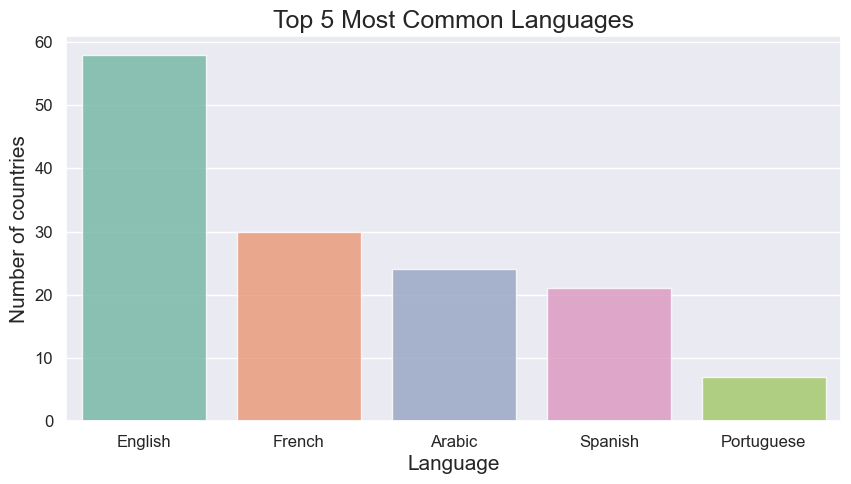

In [199]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_languages,
                 x=top_languages.index,
                 y=top_languages['Number of Countries'],
                 hue=top_languages.index,
                 alpha=0.8,
                 palette="Set2")

# labels
ax.set_title('Top 5 Most Common Languages', fontsize=18)
ax.set_xlabel('Language')
ax.set_ylabel('Number of countries')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)

plt.show()

### GINI Index

#### 10. What are the 10 countries with the most inequalities?

In [191]:
bottom_10_countries = countries.nlargest(n=10, columns='gini')[['name', 'continent', 'gini']]
bottom_10_countries

,name,continent,gini
152,South Africa,Africa,63
115,Namibia,Africa,59
157,Suriname,South America,58
184,Zambia,Africa,57
161,São Tomé and Príncipe,Africa,56
31,Central African Republic,Africa,56
52,Eswatini,Africa,55
113,Mozambique,Africa,54
23,Brazil,South America,53
17,Belize,North America,53


#### 11. What is the average GINI Index by continent?

In [214]:
avg_gini_per_continent = countries \
    .groupby('continent')[['gini']] \
    .mean() \
    .sort_values(by='gini', ascending=False)
avg_gini_per_continent

,gini
continent,
South America,46
North America,45
Africa,43
Oceania,38
Asia,35
Europe,32


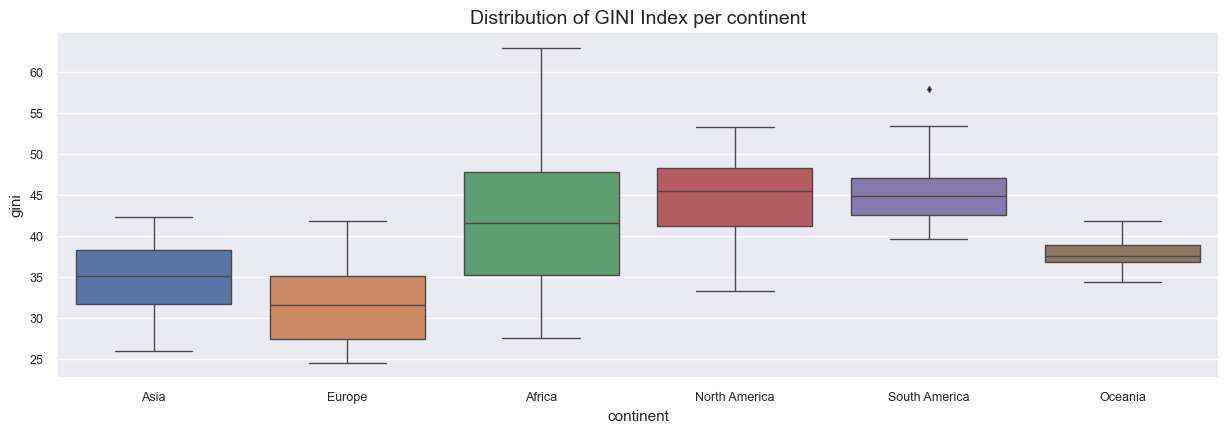

In [206]:
# Visualization of the distribution of GINI Indices by continent

# plot
flierprops = dict(marker='d', markersize=3, markerfacecolor='black')
sns.set(rc={'figure.figsize': (15, 4.5)})
ax = sns.boxplot(data=countries, x='continent', y='gini', hue='continent', flierprops=flierprops)

# labels
ax.set_title('Distribution of GINI Index per continent', fontsize=14)
ax.xaxis.label.set_size(11)
ax.yaxis.label.set_size(11)
ax.tick_params(axis='both', labelsize=9)

plt.show()